# Refine the Data

Create the items, users and interaction matrix

- **Items**: item id + metadata features
- **Users**: User id + metadata features
- **Interaction**: Explicit Matrix, Implicit Matrix

In [1]:
import sys
sys.path.append("../")

import warnings
warnings.filterwarnings("ignore")

In [2]:
import numpy as np
import pandas as pd
import re

## Items

For the items, we will keep the following:
- From `items_raw` dataframe
  - movie_id
  - title
  - year (release)
  - genre categories
- From `item_features` dataframe
  - overview
  - language (original_language)
  - runtime
  - vote_average
  - vote_count

In [3]:
items_raw = pd.read_csv("data/items_raw.csv")
item_features = pd.read_csv("data/item_features.csv")

*1. Get `year` from `release_title`* 

In [4]:
items_raw["release_date"] = pd.to_datetime(items_raw.release_date, infer_datetime_format=True)
items_raw["year"] = items_raw.release_date.apply(lambda x: str(x.year))

*2. Drop `imdb_url`,  `video_release_date` & `release_date`*

In [5]:
items_main = items_raw.drop(['video_release_date', 'release_date', 'imdb_url'], axis=1).copy()

In [6]:
# Match Whitespace + ( + YEAR + )
# regex_year = re.compile(r'\s\(\d{4}\)')
# items["movie"] = items.title.str.replace(regex_year, "")
# items["movie"] = items.movie.str.strip()

*3. Get the additional features from the item_features*

In [7]:
items_addtl = item_features[['overview', 'original_language', 'runtime', 'vote_average', 'vote_count', "movie_id"]].copy()

*4. Merge the two dataframes*

In [8]:
items = pd.merge(left=items_main, right=items_addtl, on="movie_id", how="left")

In [9]:
items.head()

,movie_id,title,genre_unknown,Action,Adventure,Animation,Children,Comedy,Crime,Documentary,...,SciFi,Thriller,War,Western,year,overview,original_language,runtime,vote_average,vote_count
0,1,Toy Story (1995),0,0,0,1,1,1,0,0,...,0,0,0,0,1995,"Led by Woody, Andy's toys live happily in his ...",en,81.0,7.9,10878.0
1,2,GoldenEye (1995),0,1,1,0,0,0,0,0,...,0,1,0,0,1995,James Bond must unmask the mysterious head of ...,en,130.0,6.8,2037.0
2,3,Four Rooms (1995),0,0,0,0,0,0,0,0,...,0,1,0,0,1995,It's Ted the Bellhop's first night on the job....,en,98.0,6.1,1251.0
3,4,Get Shorty (1995),0,1,0,0,0,1,0,0,...,0,0,0,0,1995,Chili Palmer is a Miami mobster who gets sent ...,en,105.0,6.5,501.0
4,5,Copycat (1995),0,0,0,0,0,0,1,0,...,0,1,0,0,1995,An agoraphobic psychologist and a female detec...,en,124.0,6.5,424.0


In [10]:
items.overview.isna().sum()

18

In [11]:
items.overview.fillna("None", inplace=True)

# Image Features

In [12]:
from keras.models import Model
from keras.applications.inception_v3 import InceptionV3
from keras.models import Model
from os import listdir
from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

In [13]:
base_modelv3 = InceptionV3(weights='imagenet', include_top=False)

In [14]:
model= Model(inputs=base_modelv3.input,  outputs=base_modelv3.output)

In [15]:
# model.summary()

In [16]:
def preprocess_input(x):
    x /= 255.
    x -= 0.5
    x *= 2.
    return x

In [17]:
images = []
for name in listdir("data/posters"):
    images.append(name)

In [18]:
images_1 = images[:1000]

In [19]:
def load_photos_predict(directory):
    images = []
    for name in images_1:
    
        filename = directory + '/' + name
        image = load_img(filename, target_size=(299, 299))
        # convert the image pixels to a numpy array
        image = img_to_array(image)
        # reshape data for the model
        image = np.expand_dims(image, axis=0)
        # prepare the image for the  model
        image = preprocess_input(image)
        # get image id
        image_id = name.split('.')[0]
        feature = model.predict(image).ravel()
        images.append(feature)
        
    return images

In [20]:
%%time
poster_features = load_photos_predict("data/posters")

1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 520ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 439ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 479ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 746ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 670ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 946ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 659ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 729ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 563ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 598ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 719ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 511ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 564ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 484ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 529ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 551ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 513ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 864ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 542ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 576ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 512ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 506ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 447ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 493ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 471ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 434ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 477ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 475ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 527ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 510ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 443ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 461ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 473ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 502ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 442ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 499ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 436ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 495ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 311ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 354ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 765ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 440ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 375ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 363ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 468ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 369ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 409ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 275ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 247ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 248ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 264ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 251ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 314ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 260ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 256ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 244ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 304ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 642ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 717ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 394ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 296ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 391ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 364ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 337ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 297ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 336ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 419ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 397ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 403ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 595ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 645ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 578ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 557ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 707ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 343ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 333ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 412ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 430ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 330ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 368ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 381ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 816ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 345ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 319ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 291ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 322ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 531ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 462ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 657ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 571ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 748ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 300ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 634ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 654ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 685ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 655ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 582ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 554ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 550ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 721ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 812ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 580ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [21]:
poster_features[:2]

[array([1.0484881, 0.       , 0.       , ..., 0.       , 0.       ,
        0.       ], dtype=float32),
 array([0.       , 0.       , 0.       , ..., 0.2828894, 0.       ,
        0.6466378], dtype=float32)]

# Build nearest neighbor model

In [22]:
from reco.recommend import get_similar
from sklearn.neighbors import NearestNeighbors, VALID_METRICS
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

In [23]:
from sklearn.neighbors import NearestNeighbors
from sklearn.metrics.pairwise import cosine_distances, cosine_similarity

In [24]:
def get_similar(embedding, k):
    model_similar_items = NearestNeighbors(n_neighbors=k, metric="cosine",
                                           algorithm="brute").fit(embedding)
    distances, indices = model_similar_items.kneighbors(embedding)
    
    return distances, indices

In [25]:
%%time
item_distances, item_similar_indices = get_similar(poster_features[:100], 5)

Wall time: 1.08 s


In [26]:
item_similar_indices[:5]

array([[ 0, 34, 87, 88, 89],
       [ 1,  3, 43, 32, 53],
       [ 2,  6, 24, 42, 74],
       [ 3,  1, 95, 59,  4],
       [ 4, 53, 18, 33, 16]], dtype=int64)

In [1]:
def show_similar(item_index, item_similar_indices):
        
    movie_ids = item_similar_indices[item_index]
    #movie_ids = item_encoder.inverse_transform(s)

    images = []
    for movie_id in movie_ids:
        img_path = 'data/posters/' + str(movie_id+1) + '.jpg'
        images.append(mpimg.imread(img_path))

    plt.figure(figsize=(20,10))
    columns = 5
    for i, image in enumerate(images):
        plt.subplot(len(images) // columns + 1, columns, i + 1)
        plt.axis('off')
        plt.imshow(image)

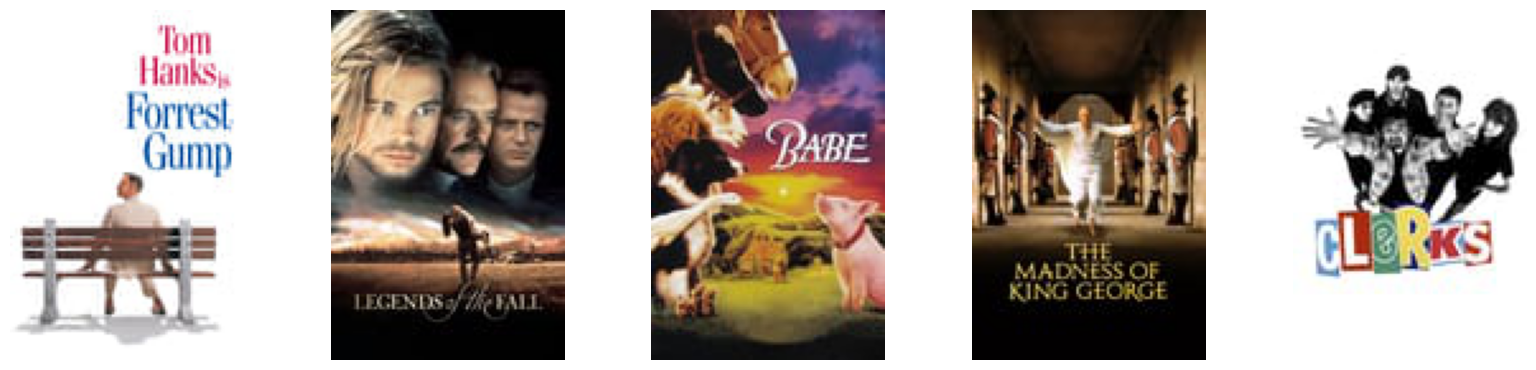

In [31]:
show_similar(68, item_similar_indices)